 Time Series

In [1]:
!rm jena_climate_2009_2016.csv.zip


rm: cannot remove ‘jena_climate_2009_2016.csv.zip’: No such file or directory


In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-05 19:45:34--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.76.94, 16.182.73.104, 16.182.65.24, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.76.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

100%[======================================>] 13,565,642  10.0MB/s   in 1.3s   

2023-11-05 19:45:35 (10.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


PROCESSING THE DATA:

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


PLOTTING THE TEMPARATURE SERIES:

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

PLOTTING THE FIRST 10 SERIES:

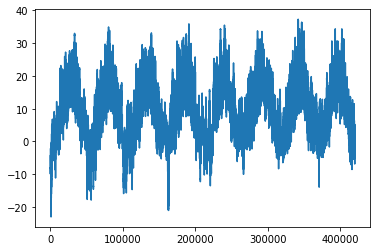

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

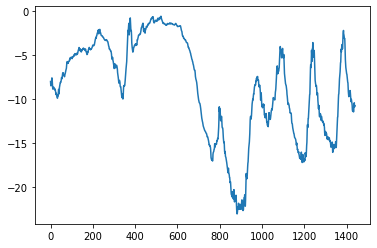

In [6]:
plt.plot(range(1440), temperature[:1440])

COMPUTING THE SAMPLES USED FOR EACH DATA SPLIT:

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


NORMALISING THE DATA:

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


TRAINING,TEST AND VALIDATION DATA SET:

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
OUTPUT:

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


COMPUTING THE BASELINE MAE: NON MACHINE LEARNING BASELINE

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


TRAINING & EVALUATING BASIC MACHINE LEARNING MODEL: DENSE LAYER

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=7,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/7
819/819 [==============================] - 27s 31ms/step - loss: 13.2995 - mae: 2.8032 - val_loss: 13.0390 - val_mae: 2.8677
Epoch 2/7
819/819 [==============================] - 26s 31ms/step - loss: 9.2294 - mae: 2.3870 - val_loss: 12.6537 - val_mae: 2.8345
Epoch 3/7
819/819 [==============================] - 26s 31ms/step - loss: 8.5313 - mae: 2.2947 - val_loss: 11.6588 - val_mae: 2.6997
Epoch 4/7
819/819 [==============================] - 24s 29ms/step - loss: 8.0392 - mae: 2.2305 - val_loss: 10.8673 - val_mae: 2.6056
Epoch 5/7
819/819 [==============================] - 25s 30ms/step - loss: 7.6449 - mae: 2.1748 - val_loss: 10.3317 - val_mae: 2.5345
Epoch 6/7
819/819 [==============================] - 24s 30ms/step - loss: 7.4097 - mae: 2.1405 - val_loss: 10.2984 - val_mae: 2.5230
Epoch 7/7
405/405 [==============================] - 8s 19ms/step - loss: 11.4269 - mae: 2.6639
Test MAE: 2.66


PLOTING THE RESULT:

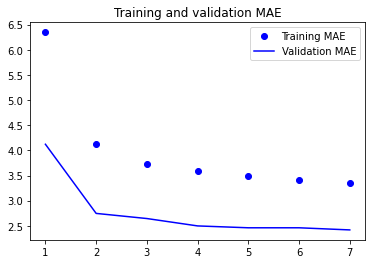

In [20]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

1D CONVOLUTION MODEL:

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=7,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/7
819/819 [==============================] - 60s 72ms/step - loss: 23.6116 - mae: 3.8005 - val_loss: 16.3333 - val_mae: 3.2228
Epoch 2/7
819/819 [==============================] - 59s 72ms/step - loss: 16.3726 - mae: 3.2044 - val_loss: 14.7552 - val_mae: 3.0325
Epoch 3/7
819/819 [==============================] - 58s 71ms/step - loss: 14.7005 - mae: 3.0401 - val_loss: 14.9092 - val_mae: 3.0411
Epoch 4/7
819/819 [==============================] - 58s 71ms/step - loss: 13.7397 - mae: 2.9408 - val_loss: 14.6412 - val_mae: 3.0347
Epoch 5/7
819/819 [==============================] - 59s 72ms/step - loss: 12.9683 - mae: 2.8536 - val_loss: 16.2347 - val_mae: 3.1999
Epoch 6/7
819/819 [==============================] - 58s 71ms/step - loss: 12.3403 - mae: 2.7831 - val_loss: 16.9989 - val_mae: 3.2390
Epoch 7/7
405/405 [==============================] - 12s 29ms/step - loss: 16.3334 - mae: 3.1985
Test MAE: 3.20


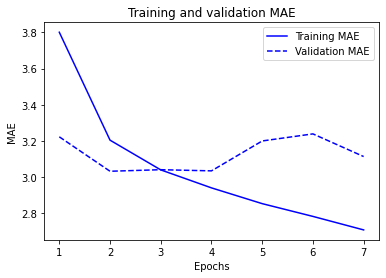

In [26]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="solid", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM BASED MODEL: FIRST RECURRENT BASELINE

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=7,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/7
819/819 [==============================] - 68s 80ms/step - loss: 39.6437 - mae: 4.5914 - val_loss: 12.1645 - val_mae: 2.6560
Epoch 2/7
819/819 [==============================] - 64s 78ms/step - loss: 10.9491 - mae: 2.5706 - val_loss: 9.9731 - val_mae: 2.4607
Epoch 3/7
819/819 [==============================] - 62s 75ms/step - loss: 9.7183 - mae: 2.4295 - val_loss: 9.7276 - val_mae: 2.4247
Epoch 4/7
819/819 [==============================] - 65s 80ms/step - loss: 9.2310 - mae: 2.3651 - val_loss: 9.7745 - val_mae: 2.4259
Epoch 5/7
819/819 [==============================] - 65s 80ms/step - loss: 8.9661 - mae: 2.3311 - val_loss: 9.7748 - val_mae: 2.4305
Epoch 6/7
819/819 [==============================] - 65s 80ms/step - loss: 8.6958 - mae: 2.2943 - val_loss: 9.7569 - val_mae: 2.4362
Epoch 7/7
405/405 [==============================] - 13s 32ms/step - loss: 10.5993 - mae: 2.5655
Test MAE: 2.57


In [ ]:
SIMPLE RNN MODEL:

In [28]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=7,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/7
819/819 [==============================] - 43s 52ms/step - loss: 139.0193 - mae: 9.7127 - val_loss: 144.4249 - val_mae: 9.9398
Epoch 2/7
819/819 [==============================] - 43s 53ms/step - loss: 136.4810 - mae: 9.5684 - val_loss: 143.7353 - val_mae: 9.8730
Epoch 3/7
819/819 [==============================] - 43s 53ms/step - loss: 136.2950 - mae: 9.5525 - val_loss: 143.6657 - val_mae: 9.8670
Epoch 4/7
819/819 [==============================] - 43s 52ms/step - loss: 136.2354 - mae: 9.5472 - val_loss: 143.6259 - val_mae: 9.8634
Epoch 5/7
819/819 [==============================] - 43s 52ms/step - loss: 136.2116 - mae: 9.5427 - val_loss: 143.5809 - val_mae: 9.8537
Epoch 6/7
819/819 [==============================] - 42s 52ms/step - loss: 136.1713 - mae: 9.5382 - val_loss: 143.5684 - val_mae: 9.8526
Epoch 7/7
405/405 [==============================] - 10s 25ms/step - loss: 151.2899 - mae: 9.9169
Test MAE: 9.92


STACKING RNN LAYERS:

In [29]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

(None, 16)
(None, 120, 16)


LSTM - SIMPLE

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=7,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/7
819/819 [==============================] - 56s 66ms/step - loss: 47.0226 - mae: 5.0047 - val_loss: 13.5562 - val_mae: 2.7893
Epoch 2/7
819/819 [==============================] - 53s 65ms/step - loss: 11.0616 - mae: 2.5803 - val_loss: 9.7256 - val_mae: 2.4234
Epoch 3/7
819/819 [==============================] - 54s 65ms/step - loss: 9.4351 - mae: 2.3981 - val_loss: 9.9041 - val_mae: 2.4479
Epoch 4/7
819/819 [==============================] - 51s 63ms/step - loss: 8.8802 - mae: 2.3278 - val_loss: 9.9444 - val_mae: 2.4627
Epoch 5/7
819/819 [==============================] - 51s 62ms/step - loss: 8.4791 - mae: 2.2742 - val_loss: 9.9536 - val_mae: 2.4617
Epoch 6/7
819/819 [==============================] - 52s 63ms/step - loss: 8.2030 - mae: 2.2396 - val_loss: 10.0402 - val_mae: 2.4709
Epoch 7/7
405/405 [==============================] - 11s 27ms/step - loss: 10.9719 - mae: 2.5921
Test MAE: 2.59


PLOT THE LSTM:

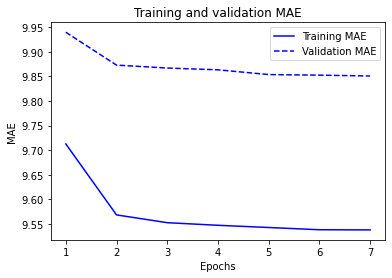

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue",linestyle="solid",label="Training MAE")
plt.plot(epochs,  val_loss, color="blue", linestyle="dashed",label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


LSTM- DROPOUT REGULARIZATION

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=7,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/7
819/819 [==============================] - 146s 176ms/step - loss: 45.1965 - mae: 5.0064 - val_loss: 13.0267 - val_mae: 2.7319
Epoch 2/7
730/819 [=========================>....] - ETA: 14s - loss: 19.9908 - mae: 3.4306

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="black", linestyle="dashdot", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashdot", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM- 8 LAYERS

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=7,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/7
819/819 [==============================] - 73s 86ms/step - loss: 66.5505 - mae: 6.1977 - val_loss: 32.5827 - val_mae: 4.2437
Epoch 2/7
819/819 [==============================] - 73s 89ms/step - loss: 19.6884 - mae: 3.2833 - val_loss: 13.0442 - val_mae: 2.7470
Epoch 3/7
819/819 [==============================] - 68s 83ms/step - loss: 10.8644 - mae: 2.5553 - val_loss: 10.7928 - val_mae: 2.5670
Epoch 4/7
819/819 [==============================] - 75s 91ms/step - loss: 9.7278 - mae: 2.4324 - val_loss: 10.1817 - val_mae: 2.4860
Epoch 5/7
819/819 [==============================] - 78s 95ms/step - loss: 9.4322 - mae: 2.3940 - val_loss: 9.9864 - val_mae: 2.4638
Epoch 6/7
819/819 [==============================] - 82s 100ms/step - loss: 9.2045 - mae: 2.3646 - val_loss: 10.0388 - val_mae: 2.4600
Epoch 7/7
405/405 [==============================] - 10s 24ms/step - loss: 10.8690 - mae: 2.5984
Test MAE: 2.60


In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="solid", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM - 16 LAYERS

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=7,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/7
819/819 [==============================] - 95s 112ms/step - loss: 40.4396 - mae: 4.5995 - val_loss: 13.0213 - val_mae: 2.7410
Epoch 2/7
819/819 [==============================] - 93s 113ms/step - loss: 10.1922 - mae: 2.4755 - val_loss: 9.5310 - val_mae: 2.3967
Epoch 3/7
819/819 [==============================] - 93s 113ms/step - loss: 8.8859 - mae: 2.3198 - val_loss: 9.4881 - val_mae: 2.4008
Epoch 4/7
819/819 [==============================] - 93s 114ms/step - loss: 8.3576 - mae: 2.2506 - val_loss: 10.1544 - val_mae: 2.4799
Epoch 5/7
819/819 [==============================] - 92s 112ms/step - loss: 7.9404 - mae: 2.1958 - val_loss: 10.2832 - val_mae: 2.5040
Epoch 6/7
819/819 [==============================] - 85s 104ms/step - loss: 7.6751 - mae: 2.1572 - val_loss: 10.0266 - val_mae: 2.4688
Epoch 7/7
405/405 [==============================] - 15s 36ms/step - loss: 11.5874 - mae: 2.6785
Test MAE: 2.68


In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="solid", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM -  32 LAYERS

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=7,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/7
819/819 [==============================] - 123s 147ms/step - loss: 19.0733 - mae: 3.1502 - val_loss: 10.5564 - val_mae: 2.5522
Epoch 2/7
819/819 [==============================] - 121s 148ms/step - loss: 7.9323 - mae: 2.2019 - val_loss: 10.7405 - val_mae: 2.5648
Epoch 3/7
819/819 [==============================] - 120s 146ms/step - loss: 6.3938 - mae: 1.9750 - val_loss: 11.7384 - val_mae: 2.6851
Epoch 4/7
819/819 [==============================] - 116s 141ms/step - loss: 5.2708 - mae: 1.7918 - val_loss: 12.1749 - val_mae: 2.7385
Epoch 5/7
819/819 [==============================] - 118s 144ms/step - loss: 4.3911 - mae: 1.6336 - val_loss: 13.1748 - val_mae: 2.8172
Epoch 6/7
819/819 [==============================] - 119s 145ms/step - loss: 3.7401 - mae: 1.5048 - val_loss: 14.1781 - val_mae: 2.9448
Epoch 7/7
405/405 [==============================] - 20s 47ms/step - loss: 11.2179 - mae: 2.6228
Test MAE: 2.62


LSTM- DROUPOUT, REGULARISED AND STACK MODEL

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=7,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/7
819/819 [==============================] - 232s 279ms/step - loss: 68.9645 - mae: 6.3491 - val_loss: 31.1883 - val_mae: 4.1217
Epoch 2/7
819/819 [==============================] - 231s 282ms/step - loss: 30.4259 - mae: 4.1343 - val_loss: 13.4328 - val_mae: 2.7466
Epoch 3/7
819/819 [==============================] - 230s 281ms/step - loss: 24.3147 - mae: 3.7318 - val_loss: 11.7295 - val_mae: 2.6444
Epoch 4/7
819/819 [==============================] - 229s 279ms/step - loss: 22.4774 - mae: 3.5878 - val_loss: 10.4721 - val_mae: 2.4977
Epoch 5/7
819/819 [==============================] - 229s 280ms/step - loss: 21.1514 - mae: 3.4877 - val_loss: 10.0972 - val_mae: 2.4605
Epoch 6/7
819/819 [==============================] - 229s 279ms/step - loss: 20.2269 - mae: 3.4134 - val_loss: 10.0748 - val_mae: 2.4606
Epoch 7/7
405/405 [==============================] - 20s 48ms/step - loss: 11.1056 - mae: 2.5970
Test MAE: 2.60


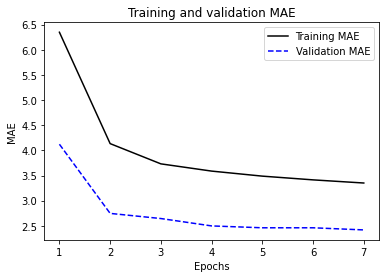

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="black", linestyle="solid", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

BIDIRECTIONAL LSTM

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=7,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/7
819/819 [==============================] - 115s 137ms/step - loss: 26.0296 - mae: 3.6744 - val_loss: 10.1256 - val_mae: 2.4739
Epoch 2/7
819/819 [==============================] - 115s 140ms/step - loss: 9.6192 - mae: 2.4264 - val_loss: 10.0175 - val_mae: 2.4432
Epoch 3/7
819/819 [==============================] - 115s 140ms/step - loss: 8.4948 - mae: 2.2761 - val_loss: 9.7029 - val_mae: 2.4051
Epoch 4/7
819/819 [==============================] - 115s 140ms/step - loss: 7.8801 - mae: 2.1936 - val_loss: 9.9285 - val_mae: 2.4333
Epoch 5/7
819/819 [==============================] - 115s 141ms/step - loss: 7.5119 - mae: 2.1421 - val_loss: 10.0455 - val_mae: 2.4487
Epoch 6/7
819/819 [==============================] - 115s 140ms/step - loss: 7.2317 - mae: 2.1007 - val_loss: 10.0826 - val_mae: 2.4536
Epoch 7/7
405/405 [==============================] - 19s 46ms/step - loss: 11.4603 - mae: 2.6055
Test MAE: 2.61


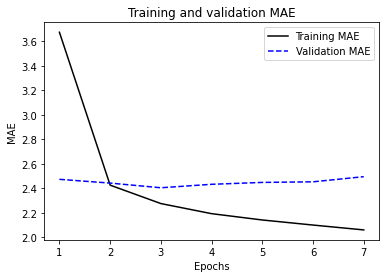

In [22]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="black", linestyle="solid", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

COMBINE 1 D CONVENT AND LSTM:

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=7,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/7
819/819 [==============================] - 118s 141ms/step - loss: 26.2874 - mae: 3.6911 - val_loss: 10.5428 - val_mae: 2.5172
Epoch 2/7
819/819 [==============================] - 115s 141ms/step - loss: 9.5115 - mae: 2.4100 - val_loss: 9.9082 - val_mae: 2.4252
Epoch 3/7
819/819 [==============================] - 115s 141ms/step - loss: 8.5254 - mae: 2.2753 - val_loss: 9.9273 - val_mae: 2.4359
Epoch 4/7
819/819 [==============================] - 115s 140ms/step - loss: 7.9265 - mae: 2.1944 - val_loss: 10.3498 - val_mae: 2.4872
Epoch 5/7
819/819 [==============================] - 115s 141ms/step - loss: 7.5152 - mae: 2.1347 - val_loss: 10.8683 - val_mae: 2.5475
Epoch 6/7
819/819 [==============================] - 115s 140ms/step - loss: 7.1626 - mae: 2.0819 - val_loss: 11.0660 - val_mae: 2.5724
Epoch 7/7
405/405 [==============================] - 19s 46ms/step - loss: 10.9262 - mae: 2.61541s
Test MAE: 2.62


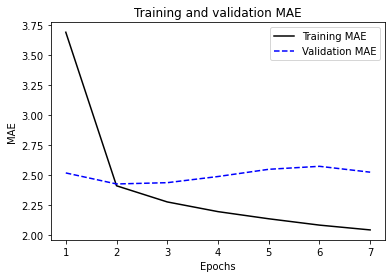

In [24]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="black", linestyle="solid", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()